# 00 Import libraries

In [1]:
import numpy as np
import json
import torch
from scipy.stats import ttest_ind, levene
import os
import seaborn as sns
import matplotlib.pyplot as plt
#import ants
import nibabel as nib
from nilearn import plotting
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 01 load coordinates

In [2]:
data = nib.load('../data/atlas/HCPMMP1_for_ABIDE.nii.gz') # original
#data = nib.load('../../../rsfMRIQC/atlas_HCPMMP1_on_MNI152_ICBM2009a_nlin_resized.nii') # symmetric

In [3]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=data)
# scaler = StandardScaler()
# scaled_coordinates = scaler.fit_transform(coordinates)

# 02 load interpretability

In [4]:
healthy_path = '../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target0'
sub_list = list(set([i.split('_')[0] for i in os.listdir(healthy_path)]))

In [5]:
high_contribution = np.zeros((len(sub_list), 180, 180))
low_contribution = np.zeros((len(sub_list), 180, 180))
ultralow_contribution = np.zeros((len(sub_list), 180, 180))


for i, name in enumerate(sub_list):
    activation_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target0/{name}_att_mat_activation.json'
    gradient_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target0/{name}_att_mat_gradient.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    with open(gradient_path, 'r') as file:
        gradients = json.load(file)
    
    # high
    high_act = activations['high_spatial_attention']
    high_grad = gradients['high_spatial_attention']
    high_act_mean = torch.mean(torch.tensor(high_act), dim=0)
    high_grad_mean = torch.mean(torch.tensor(high_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(high_act_mean, high_grad_mean)
    high_contribution[i, :, :] = contributions
    
    # low
    low_act = activations['low_spatial_attention']
    low_grad = gradients['low_spatial_attention']
    low_act_mean = torch.mean(torch.tensor(low_act), dim=0)
    low_grad_mean = torch.mean(torch.tensor(low_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(low_act_mean, low_grad_mean)
    low_contribution[i, :, :] = contributions
    
    # ultralow
    ultralow_act = activations['ultralow_spatial_attention']
    ultralow_grad = gradients['ultralow_spatial_attention']
    ultralow_act_mean = torch.mean(torch.tensor(ultralow_act), dim=0)
    ultralow_grad_mean = torch.mean(torch.tensor(ultralow_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(ultralow_act_mean, ultralow_grad_mean)
    ultralow_contribution[i, :, :] = contributions

In [6]:
ASD_path = '../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target1'
sub_list = list(set([i.split('_')[0] for i in os.listdir(ASD_path)]))

In [7]:
high_contribution_ASD = np.zeros((len(sub_list), 180, 180))
low_contribution_ASD = np.zeros((len(sub_list), 180, 180))
ultralow_contribution_ASD = np.zeros((len(sub_list), 180, 180))


for i, name in enumerate(sub_list):
    activation_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target1/{name}_att_mat_activation.json'
    gradient_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target1/{name}_att_mat_gradient.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    with open(gradient_path, 'r') as file:
        gradients = json.load(file)
    
    # high
    high_act = activations['high_spatial_attention']
    high_grad = gradients['high_spatial_attention']
    high_act_mean = torch.mean(torch.tensor(high_act), dim=0)
    high_grad_mean = torch.mean(torch.tensor(high_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(high_act_mean, high_grad_mean)
    high_contribution_ASD[i, :, :] = contributions
    
    # low
    low_act = activations['low_spatial_attention']
    low_grad = gradients['low_spatial_attention']
    low_act_mean = torch.mean(torch.tensor(low_act), dim=0)
    low_grad_mean = torch.mean(torch.tensor(low_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(low_act_mean, low_grad_mean)
    low_contribution_ASD[i, :, :] = contributions
    
    # ultralow
    ultralow_act = activations['ultralow_spatial_attention']
    ultralow_grad = gradients['ultralow_spatial_attention']
    ultralow_act_mean = torch.mean(torch.tensor(ultralow_act), dim=0)
    ultralow_grad_mean = torch.mean(torch.tensor(ultralow_grad).squeeze(dim=0), dim=0)
    # 활성화 값과 그라디언트의 곱을 계산하여 기여도 분석
    contributions = torch.matmul(ultralow_act_mean, ultralow_grad_mean)
    ultralow_contribution_ASD[i, :, :] = contributions

# 03 t-test between ASD and HC

## 3-1 High frequency

In [8]:
p_values_high = np.zeros((180, 180))  # p-value 저장을 위한 배열 초기화
t_stats_high = np.zeros((180, 180))
cohens_d_high = np.zeros((180, 180))
for i in range(180):
    for j in range(180):
        _, p_levene = levene(high_contribution[:, i, j], high_contribution_ASD[:, i, j])
        equal_var = True if p_levene > 0.05 else False
        t_stat, p_value = ttest_ind(high_contribution[:, i, j], high_contribution_ASD[:, i, j], equal_var=equal_var)
        cohens_d = (np.mean(high_contribution[:, i, j]) - np.mean(high_contribution_ASD[:, i, j])) / np.sqrt(((len(high_contribution[:, i, j]) - 1) * np.var(high_contribution[:, i, j]) + (len(high_contribution_ASD[:, i, j]) - 1) * np.var(high_contribution_ASD[:, i, j])) / (len(high_contribution[:, i, j]) + len(high_contribution_ASD[:, i, j]) - 2))
        p_values_high[i, j] = p_value
        t_stats_high[i, j] = t_stat
        cohens_d_high[i, j] = np.abs(cohens_d)

<Axes: >

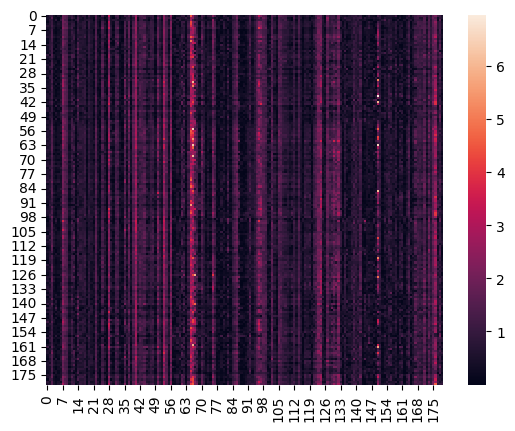

In [9]:
# effect size
sns.heatmap(cohens_d_high)

<Axes: >

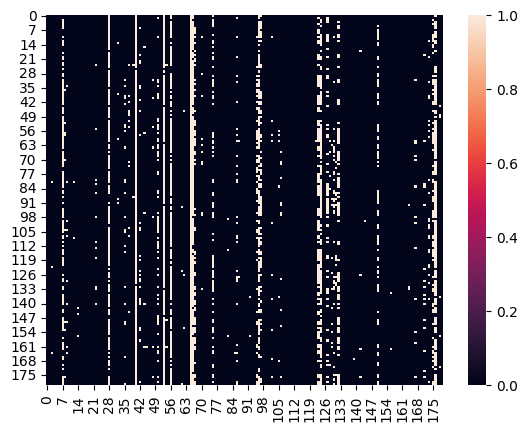

In [10]:
# 두 그룹을 분리하는 데 통계적으로 유의미한 connectivity
filtered_matrix_high = np.where(p_values_high <= 0.05, 1, 0)
sns.heatmap(filtered_matrix_high)

<Axes: >

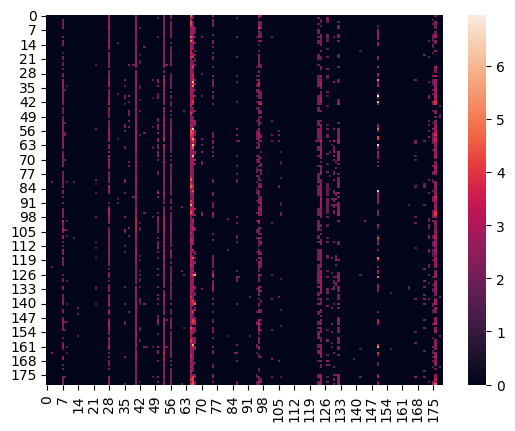

In [11]:
## 이제 여기서 effect size 높은 애들만 골라내면 됨!
sns.heatmap(cohens_d_high*filtered_matrix_high)

<Axes: >

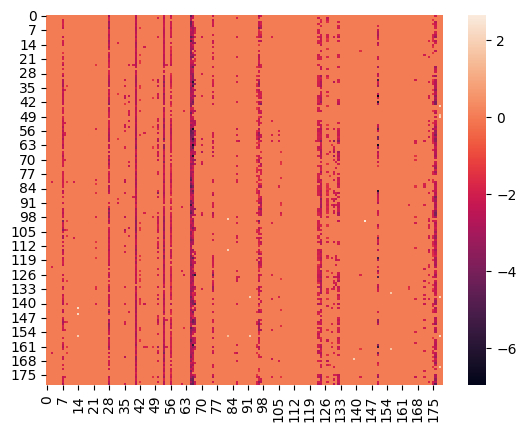

In [12]:
t_sign_high = np.where(t_stats_high < 0, -1, 1)
sns.heatmap(cohens_d_high*filtered_matrix_high*t_sign_high)

## 3-2 low frequency

In [13]:
p_values_low = np.zeros((180, 180))  # p-value 저장을 위한 배열 초기화
t_stats_low = np.zeros((180, 180))
cohens_d_low = np.zeros((180, 180))
for i in range(180):
    for j in range(180):
        _, p_levene = levene(low_contribution[:, i, j], low_contribution_ASD[:, i, j])
        equal_var = True if p_levene > 0.05 else False
        t_stat, p_value = ttest_ind(low_contribution[:, i, j], low_contribution_ASD[:, i, j], equal_var=equal_var)
        cohens_d = (np.mean(low_contribution[:, i, j]) - np.mean(low_contribution_ASD[:, i, j])) / np.sqrt(((len(low_contribution[:, i, j]) - 1) * np.var(low_contribution[:, i, j]) + (len(low_contribution_ASD[:, i, j]) - 1) * np.var(low_contribution_ASD[:, i, j])) / (len(low_contribution[:, i, j]) + len(low_contribution_ASD[:, i, j]) - 2))
        p_values_low[i, j] = p_value
        t_stats_low[i, j] = t_stat
        cohens_d_low[i, j] = np.abs(cohens_d)

<Axes: >

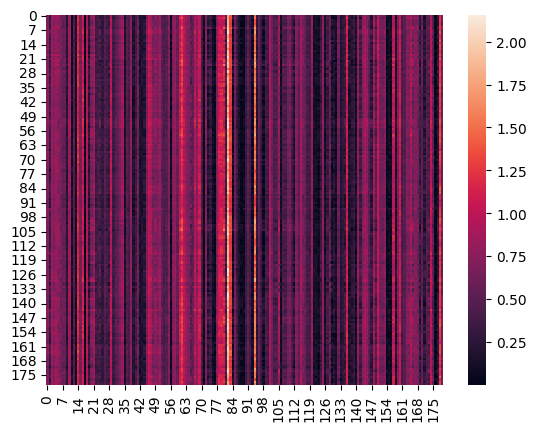

In [14]:
# effect size
sns.heatmap(cohens_d_low)

<Axes: >

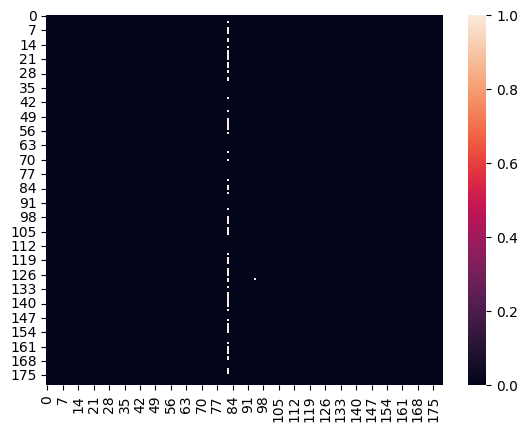

In [15]:
# 두 그룹을 분리하는 데 통계적으로 유의미한 connectivity
filtered_matrix_low = np.where(p_values_low <= 0.05, 1, 0)
sns.heatmap(filtered_matrix_low)

<Axes: >

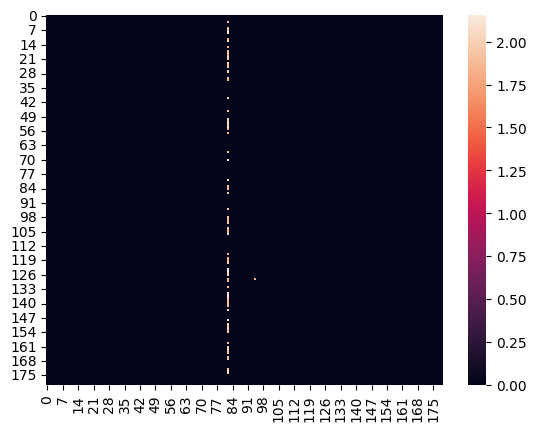

In [16]:
## 이제 여기서 effect size 높은 애들만 골라내면 됨!
sns.heatmap(cohens_d_low*filtered_matrix_low)

<Axes: >

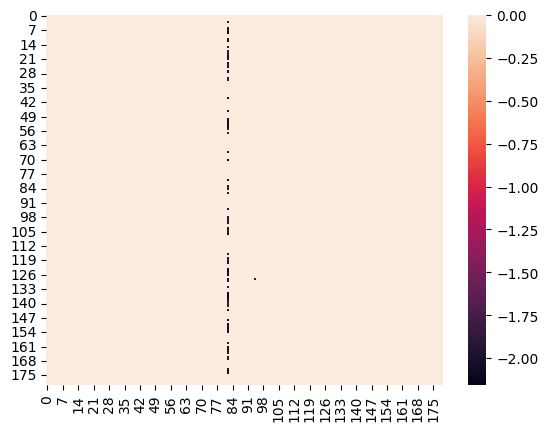

In [17]:
t_sign_low = np.where(t_stats_low < 0, -1, 1)
sns.heatmap(cohens_d_low*filtered_matrix_low*t_sign_low)

## 3-3 ultralow frequency

In [18]:
p_values_ultralow = np.zeros((180, 180))  # p-value 저장을 위한 배열 초기화
t_stats_ultralow = np.zeros((180, 180))
cohens_d_ultralow = np.zeros((180, 180))
for i in range(180):
    for j in range(180):
        _, p_levene = levene(ultralow_contribution[:, i, j], ultralow_contribution_ASD[:, i, j])
        equal_var = True if p_levene > 0.05 else False
        t_stat, p_value = ttest_ind(ultralow_contribution[:, i, j], ultralow_contribution_ASD[:, i, j], equal_var=equal_var)
        cohens_d = (np.mean(ultralow_contribution[:, i, j]) - np.mean(ultralow_contribution_ASD[:, i, j])) / np.sqrt(((len(ultralow_contribution[:, i, j]) - 1) * np.var(ultralow_contribution[:, i, j]) + (len(ultralow_contribution_ASD[:, i, j]) - 1) * np.var(ultralow_contribution_ASD[:, i, j])) / (len(ultralow_contribution[:, i, j]) + len(ultralow_contribution_ASD[:, i, j]) - 2))
        p_values_ultralow[i, j] = p_value
        t_stats_ultralow[i, j] = t_stat
        cohens_d_ultralow[i, j] = np.abs(cohens_d)

<Axes: >

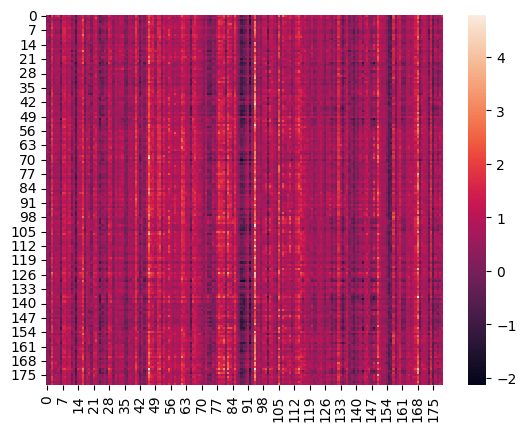

In [19]:
# t-test
sns.heatmap(t_stats_ultralow)

<Axes: >

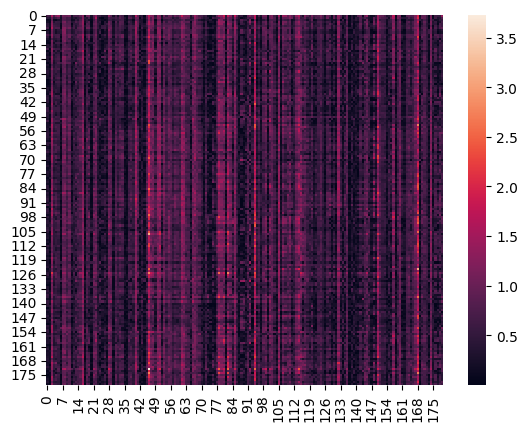

In [20]:
# effect size
sns.heatmap(cohens_d_ultralow)

<Axes: >

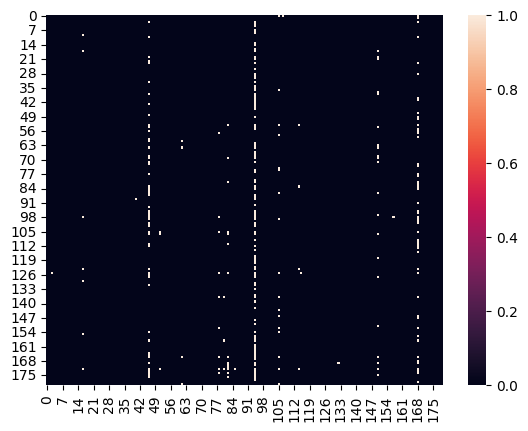

In [21]:
# 두 그룹을 분리하는 데 통계적으로 유의미한 connectivity
filtered_matrix_ultralow = np.where(p_values_ultralow <= 0.05, 1, 0)
sns.heatmap(filtered_matrix_ultralow)

<Axes: >

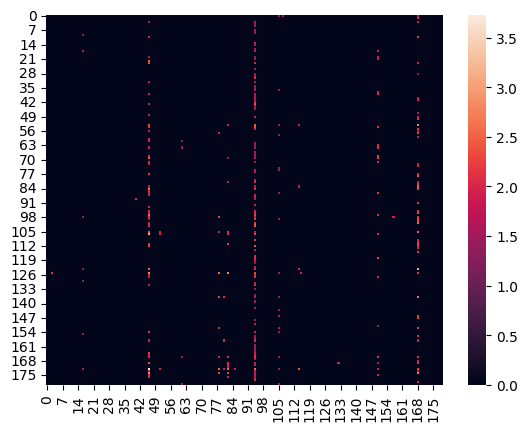

In [22]:
## 이제 여기서 effect size 높은 애들만 골라내면 됨!
sns.heatmap(cohens_d_ultralow*filtered_matrix_ultralow)

<Axes: >

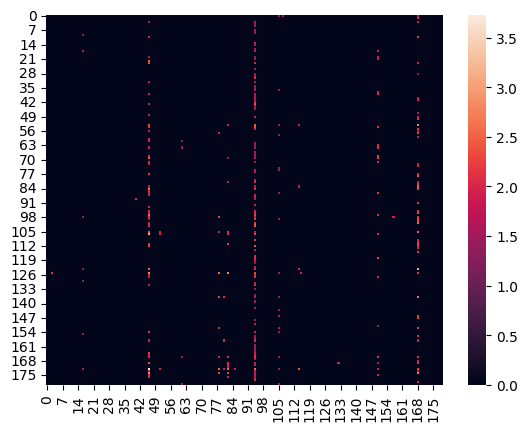

In [23]:
t_sign_ultralow = np.where(t_stats_ultralow < 0, -1, 1)
sns.heatmap(cohens_d_ultralow*filtered_matrix_ultralow*t_sign_ultralow)

<Axes: >

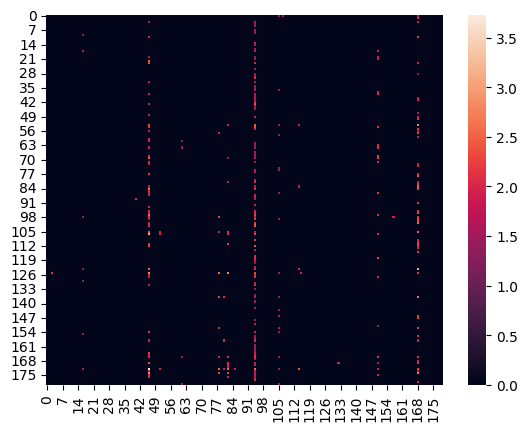

In [24]:
t_sign_ultralow = np.where(t_stats_ultralow < 0, -1, 1)
sns.heatmap(cohens_d_ultralow*filtered_matrix_ultralow*t_sign_ultralow)

# 04 Load atlas meta data

In [25]:
# symmetric (just hemisphere)
# atlas_info = pd.read_csv('../data/atlas/HCPMMP1_atlas_info.csv', encoding='unicode_escape')
# all hemispheres
atlas_info = pd.read_csv('../data/atlas/HCP-MMP1_UniqueRegionList.csv', encoding='unicode_escape')

In [26]:
atlas_info = atlas_info.replace(r'\n', ' ', regex=True)

In [27]:
atlas_info

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STSva_R,Area_STSv_anterior_R,376_R,R,STSva,Temp,Auditory_Association,376,11,32.924419,117.527907,54.337791,1720
356,TE1m_R,Area_TE1_Middle_R,377_R,R,TE1m,Temp,Lateral_Temporal,377,14,26.146605,102.236497,53.246528,2592
357,PI_R,Para-Insular_Area_R,378_R,R,PI,Temp,Insular_and_Frontal_Opercular,378,12,47.013363,123.157016,57.926503,898
358,a32pr_R,Area_anterior_32_prime_R,379_R,R,a32pr,Fr,Anterior_Cingulate_and_Medial_Prefrontal,379,19,81.723096,153.990326,102.516324,827


In [28]:
# scaled_coordinates_30 = scaled_coordinates*30
# adjusted_coordinates = scaled_coordinates_30.copy()
# adjusted_coordinates[:, 1] -= 10  # X축 좌표 수정
# adjusted_coordinates[:, 2] += 2  # Z축 좌표 수정

# 05 Visualization on a glass brain

## 5-1 High frequency

In [29]:
significant_elements = cohens_d_high*filtered_matrix_high
flattened_indices = np.argsort(-significant_elements, axis=None)[:10]

# 0으로 초기화된 마스크 생성
filtered_matrix_high_mask = np.zeros_like(filtered_matrix_high)

# 1D 인덱스를 2D 인덱스로 변환
rows, cols = np.unravel_index(flattened_indices, filtered_matrix_high.shape)

# 마스크에서 선택된 위치를 True로 설정
for row, col in zip(rows, cols):
    print(significant_elements[row, col], t_stats_high[row, col])
    if t_stats_high[row, col]==abs(t_stats_high[row, col]):
        # 양수 (HC 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_high_mask[row, col] = 1  
    else:
        # 음수 (ASD 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_high_mask[row, col] = -1

6.95027023967133 -8.966045587193562
6.5645572223252175 -8.460659284222178
6.47883370760161 -8.36229871634222
6.313012909636079 -7.565792698932467
6.134685452722881 -7.880619986049496
6.05707969989283 -7.5338099110631775
6.040724902027055 -7.731680576069353
5.959351519016973 -7.68732391312158
5.899040423657851 -7.475564821918257
5.819468525459532 -10.950308399470408


<Axes: >

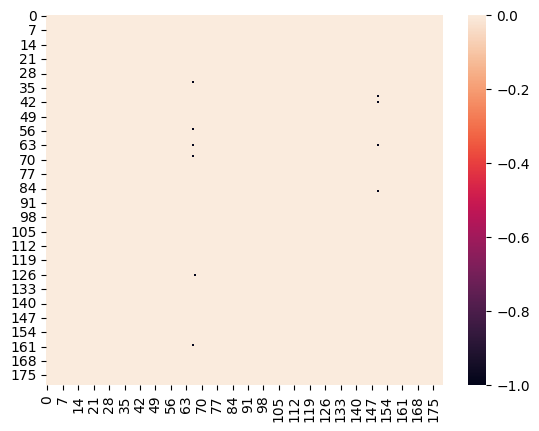

In [30]:
sns.heatmap(filtered_matrix_high_mask)

In [31]:
# original -> 이제 이 결과를 좌우 대칭으로 만들면 됨.

for i, j in zip(rows, cols):
    row = atlas_info[atlas_info['regionID'] == i][['regionLongName']].values[0][0]
    col = atlas_info[atlas_info['regionID'] == j][['regionLongName']].values[0][0]
    if filtered_matrix_high_mask[i, j] > 0:
        description = 'HC에서 뚜렷하게 나타나는 특징'
    elif filtered_matrix_high_mask[i, j] < 0:
        description = 'ASD에서 뚜렷하게 나타나는 특징'
    else:
        description = '없음'
    print(row, ',', col, description)

Area_5L_L , Area_PGi_L ASD에서 뚜렷하게 나타나는 특징
Area_8BM_L , Area_PGi_L ASD에서 뚜렷하게 나타나는 특징
Area_6mp_L , Area_47m_L ASD에서 뚜렷하게 나타나는 특징
Area_8BM_L , Area_47m_L ASD에서 뚜렷하게 나타나는 특징
Area_8Ad_L , Area_47m_L ASD에서 뚜렷하게 나타나는 특징
Area_anterior_9-46v_L , Area_PGi_L ASD에서 뚜렷하게 나타나는 특징
Area_23d_L , Area_47m_L ASD에서 뚜렷하게 나타나는 특징
Lateral_Area_7A_L , Area_PGi_L ASD에서 뚜렷하게 나타나는 특징
VentroMedial_Visual_Area_2_L , Area_47m_L ASD에서 뚜렷하게 나타나는 특징
ParaHippocampal_Area_1_L , Area_8Av_L ASD에서 뚜렷하게 나타나는 특징


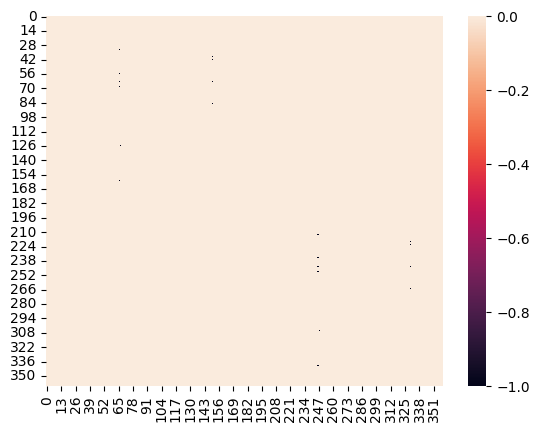

In [32]:
answer = np.zeros((360, 360))
answer[:180, :180] = filtered_matrix_high_mask
answer[180:, 180:] = filtered_matrix_high_mask
sns.heatmap(answer)

view = plotting.view_connectome(answer,coordinates, node_size=3.0)
view.save_as_html('symmetric_ASD_ROI_180_high_freq_sign.html')

In [33]:
# symmetric
# for i, j in zip(rows, cols):
#     row = atlas_info[atlas_info['Parcel\nIndex'] == i][['Area_Description']].values[0][0]
#     col = atlas_info[atlas_info['Parcel\nIndex'] == j][['Area_Description']].values[0][0]
#     if filtered_matrix_high_mask[i, j] > 0:
#         description = 'HC에서 뚜렷하게 나타나는 특징'
#     elif filtered_matrix_high_mask[i, j] < 0:
#         description = 'ASD에서 뚜렷하게 나타나는 특징'
#     else:
#         description = '없음'
#     print(row, ',', col, description)

In [34]:
# view = plotting.view_connectome(filtered_matrix_high_mask,adjusted_coordinates, node_size=3.0)
# view.save_as_html('ASD_ROI_180_high_freq_sign.html')

## 02 low

In [35]:
significant_elements = cohens_d_low*filtered_matrix_low
flattened_indices = np.argsort(-significant_elements, axis=None)[:10]

# 0으로 초기화된 마스크 생성
filtered_matrix_low_mask = np.zeros_like(filtered_matrix_low)

# 1D 인덱스를 2D 인덱스로 변환
rows, cols = np.unravel_index(flattened_indices, filtered_matrix_low.shape)

# 마스크에서 선택된 위치를 True로 설정
for row, col in zip(rows, cols):
    print(significant_elements[row, col], t_stats_low[row, col])
    if t_stats_low[row, col]==abs(t_stats_low[row, col]):
        # 양수 (HC 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_low_mask[row, col] = 1
    else:
        # 음수 (ASD 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_low_mask[row, col] = -1

2.1549496208728254 -2.7571150456326943
2.154113543975579 -2.7481795860412905
2.1229122741092477 -2.7058430956096515
2.12183180871523 -2.707072382552116
2.1163167468077506 -2.6982080903324275
2.1148400000253154 -2.693770246226617
2.109469314746954 -2.695452892034086
2.0991717836547363 -2.6783720120089822
2.078050115381327 -2.6533928203902395
2.065257519508346 -2.6240468470717975


<Axes: >

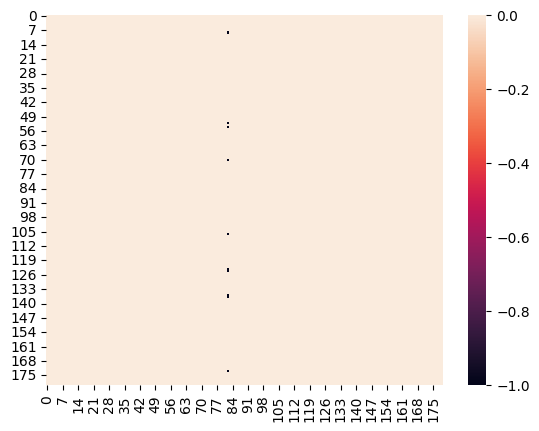

In [36]:
sns.heatmap(filtered_matrix_low_mask)

In [37]:
# original -> 이제 이 결과를 좌우 대칭으로 만들면 됨.

for i, j in zip(rows, cols):
    row = atlas_info[atlas_info['regionID'] == i][['regionLongName']].values[0][0]
    col = atlas_info[atlas_info['regionID'] == j][['regionLongName']].values[0][0]
    if filtered_matrix_low_mask[i, j] > 0:
        description = 'HC에서 뚜렷하게 나타나는 특징'
    elif filtered_matrix_low_mask[i, j] < 0:
        description = 'ASD에서 뚜렷하게 나타나는 특징'
    else:
        description = '없음'
    print(row, ',', col, description)

Area_TE2_posterior_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Area_STGa_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
ParaBelt_Complex_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Area_8B_Lateral_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Primary_Motor_Cortex_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Area_PHT_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Area_2_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Dorsal_area_6_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Medial_Belt_Complex_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징
Posterior_Insular_Area_2_L , Area_IFSa_L ASD에서 뚜렷하게 나타나는 특징


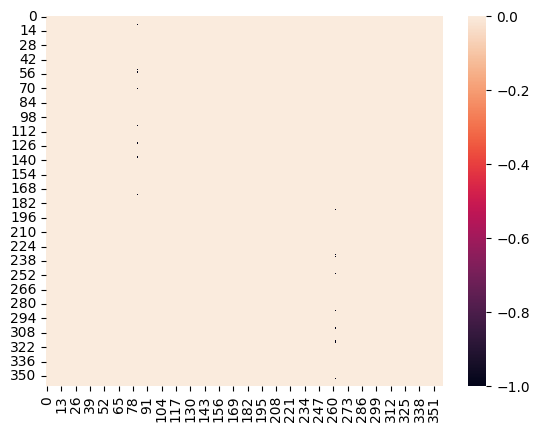

In [38]:
answer = np.zeros((360, 360))
answer[:180, :180] = filtered_matrix_low_mask
answer[180:, 180:] = filtered_matrix_low_mask
sns.heatmap(answer)

view = plotting.view_connectome(answer,coordinates, node_size=3.0)
view.save_as_html('symmetric_ASD_ROI_180_low_freq_sign.html')

In [39]:
# symmetric

# for i, j in zip(rows, cols):
#     row = atlas_info[atlas_info['Parcel\nIndex'] == i][['Area_Description']].values[0][0]
#     col = atlas_info[atlas_info['Parcel\nIndex'] == j][['Area_Description']].values[0][0]
#     if filtered_matrix_low_mask[i, j] > 0:
#         description = 'HC에서 뚜렷하게 나타나는 특징'
#     elif filtered_matrix_low_mask[i, j] < 0:
#         description = 'ASD에서 뚜렷하게 나타나는 특징'
#     else:
#         description = '없음'
#     print(row, ',', col, description)

In [40]:
# view = plotting.view_connectome(filtered_matrix_low_mask, adjusted_coordinates, node_size=3.0)
# view.save_as_html('ASD_ROI_180_low_freq_sign.html')

## 5-3 ultralow

In [41]:
significant_elements = cohens_d_ultralow*filtered_matrix_ultralow
flattened_indices = np.argsort(-significant_elements, axis=None)[:10]

# 0으로 초기화된 마스크 생성
filtered_matrix_ultralow_mask = np.zeros_like(filtered_matrix_ultralow)

# 1D 인덱스를 2D 인덱스로 변환
rows, cols = np.unravel_index(flattened_indices, filtered_matrix_ultralow.shape)

# 마스크에서 선택된 위치를 True로 설정
for row, col in zip(rows, cols):
    print(significant_elements[row, col], t_stats_ultralow[row, col])
    if t_stats_ultralow[row, col]==abs(t_stats_ultralow[row, col]):
        # 양수 (HC 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_ultralow_mask[row, col] = 1
    else:
        # 음수 (ASD 에서 뚜렷하게 나타나는 특징)
        filtered_matrix_ultralow_mask[row, col] = -1

3.7281402922146523 4.772842562678235
3.15736978223894 4.065716961771558
3.1194554199237605 4.003205968795545
2.78077597971329 3.587565381955714
2.752402508410971 3.5432860062111984
2.739093119162922 3.4285869792027404
2.728817881436533 3.506398403650111
2.6962012699812616 3.4389351677586086
2.5702088270986794 4.727580625570145
2.5510376987889996 3.283197019149072


<Axes: >

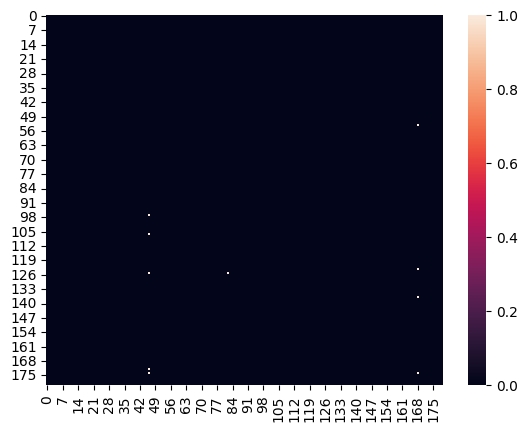

In [42]:
sns.heatmap(filtered_matrix_ultralow_mask)

In [43]:
# original -> 이제 이 결과를 좌우 대칭으로 만들면 됨.

for i, j in zip(rows, cols):
    row = atlas_info[atlas_info['regionID'] == i][['regionLongName']].values[0][0]
    col = atlas_info[atlas_info['regionID'] == j][['regionLongName']].values[0][0]
    if filtered_matrix_ultralow_mask[i, j] > 0:
        description = 'HC에서 뚜렷하게 나타나는 특징'
    elif filtered_matrix_ultralow_mask[i, j] < 0:
        description = 'ASD에서 뚜렷하게 나타나는 특징'
    else:
        description = '없음'
    print(row, ',', col, description)

Area_TG_Ventral_L , Lateral_Area_7P_L HC에서 뚜렷하게 나타나는 특징
Posterior_Insular_Area_2_L , Lateral_Area_7P_L HC에서 뚜렷하게 나타나는 특징
Area_STGa_L , Insular_Granular_Complex_L HC에서 뚜렷하게 나타나는 특징
Area_3a_L , Insular_Granular_Complex_L HC에서 뚜렷하게 나타나는 특징
Auditory_5_Complex_L , Lateral_Area_7P_L HC에서 뚜렷하게 나타나는 특징
Lateral_Belt_Complex_L , Lateral_Area_7P_L HC에서 뚜렷하게 나타나는 특징
Auditory_5_Complex_L , Area_IFSa_L HC에서 뚜렷하게 나타나는 특징
Lateral_Belt_Complex_L , Insular_Granular_Complex_L HC에서 뚜렷하게 나타나는 특징
Area_PHT_L , Insular_Granular_Complex_L HC에서 뚜렷하게 나타나는 특징
Inferior_6-8_Transitional_Area_L , Lateral_Area_7P_L HC에서 뚜렷하게 나타나는 특징


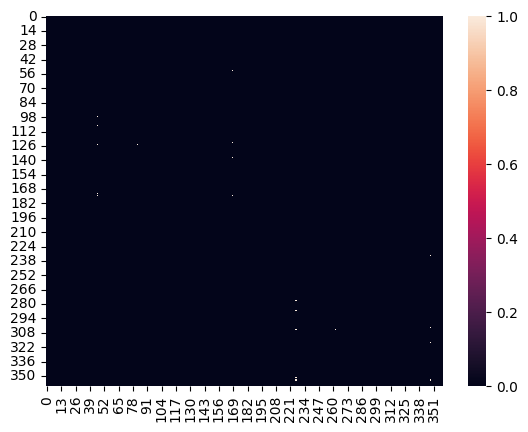

In [44]:
answer = np.zeros((360, 360))
answer[:180, :180] = filtered_matrix_ultralow_mask
answer[180:, 180:] = filtered_matrix_ultralow_mask
sns.heatmap(answer)

view = plotting.view_connectome(answer,coordinates, node_size=3.0)
view.save_as_html('symmetric_ASD_ROI_180_ultralow_freq_sign.html')

In [45]:
# symmetric

# for i, j in zip(rows, cols):
#     row = atlas_info[atlas_info['Parcel\nIndex'] == i][['Area_Description']].values[0][0]
#     col = atlas_info[atlas_info['Parcel\nIndex'] == j][['Area_Description']].values[0][0]
#     if filtered_matrix_ultralow_mask[i, j] > 0:
#         description = 'HC에서 뚜렷하게 나타나는 특징'
#     elif filtered_matrix_ultralow_mask[i, j] < 0:
#         description = 'ASD에서 뚜렷하게 나타나는 특징'
#     else:
#         description = '없음'
#     print(row, ',', col, description)

In [46]:
# view = plotting.view_connectome(filtered_matrix_ultralow_mask, adjusted_coordinates, node_size=3.0)
# view.save_as_html('ASD_ROI_180_ultralow_freq_sign.html')

# 06 attention matrix distribution between HC and ASD

In [47]:
healthy_path = '../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target0'
sub_list = list(set([i.split('_')[0] for i in os.listdir(healthy_path)]))

high_HC = np.zeros((len(sub_list), 180, 180))
low_HC = np.zeros((len(sub_list), 180, 180))
ultralow_HC = np.zeros((len(sub_list), 180, 180))

for i, name in enumerate(sub_list):
    activation_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target0/{name}_att_mat_activation.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    
    # high
    high_act = activations['high_spatial_attention']
    high_act_mean = torch.mean(torch.tensor(high_act), dim=0)
    high_HC[i, :, :] = high_act_mean #contributions
    
    # low
    low_act = activations['low_spatial_attention']
    low_act_mean = torch.mean(torch.tensor(low_act), dim=0)
    low_HC[i, :, :] = low_act_mean # contributions
    
    # ultralow
    ultralow_act = activations['ultralow_spatial_attention']
    ultralow_act_mean = torch.mean(torch.tensor(ultralow_act), dim=0)
    ultralow_HC[i, :, :] = ultralow_act_mean #contributions

In [48]:
ASD_path = '../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target1'
sub_list = list(set([i.split('_')[0] for i in os.listdir(ASD_path)]))

high_ASD = np.zeros((len(sub_list), 180, 180))
low_ASD = np.zeros((len(sub_list), 180, 180))
ultralow_ASD = np.zeros((len(sub_list), 180, 180))

for i, name in enumerate(sub_list):
    activation_path = f'../visualization/ABIDE_spatiotemporal_three_divfreqBERT_HCPMMP1_ASD/ABIDE_target1/{name}_att_mat_activation.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    
    # high
    high_act = activations['high_spatial_attention']
    high_act_mean = torch.mean(torch.tensor(high_act), dim=0)
    high_ASD[i, :, :] = high_act_mean #contributions
    
    # low
    low_act = activations['low_spatial_attention']
    low_act_mean = torch.mean(torch.tensor(low_act), dim=0)
    low_ASD[i, :, :] = low_act_mean # contributions
    
    # ultralow
    ultralow_act = activations['ultralow_spatial_attention']
    ultralow_act_mean = torch.mean(torch.tensor(ultralow_act), dim=0)
    ultralow_ASD[i, :, :] = ultralow_act_mean #contributions

## 6-1 high frequency

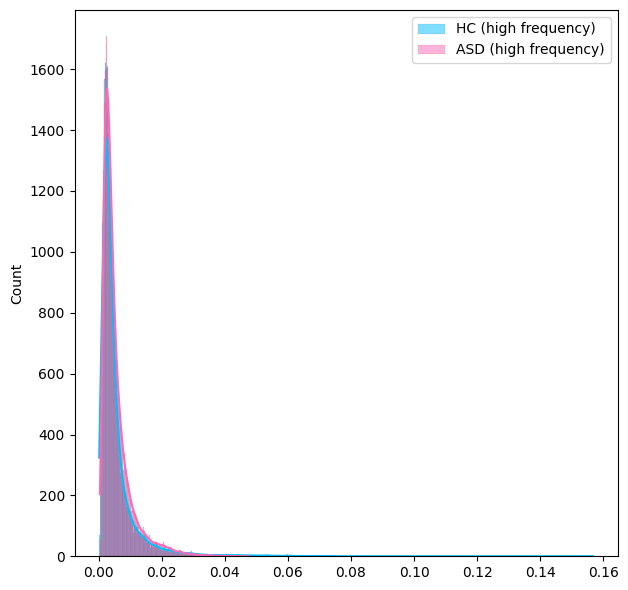

In [49]:
# 데이터를 1차원으로 변환
high_HC_flat = np.mean(high_HC, axis=0).flatten()
high_ASD_flat = np.mean(high_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(high_HC_flat, kde=True, color='deepskyblue', label='HC (high frequency)')
sns.histplot(high_ASD_flat, kde=True, color='hotpink', label='ASD (high frequency)')
plt.legend()
# plt.title('Histogram of high frequency range (attention matrix), averaged subjects')

plt.tight_layout()
plt.savefig('ABIDE_ASD_high_freq_histplot.png', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches='tight', 
    pad_inches=0.1,
    metadata=None)
plt.show()

## 6-2 low frequency

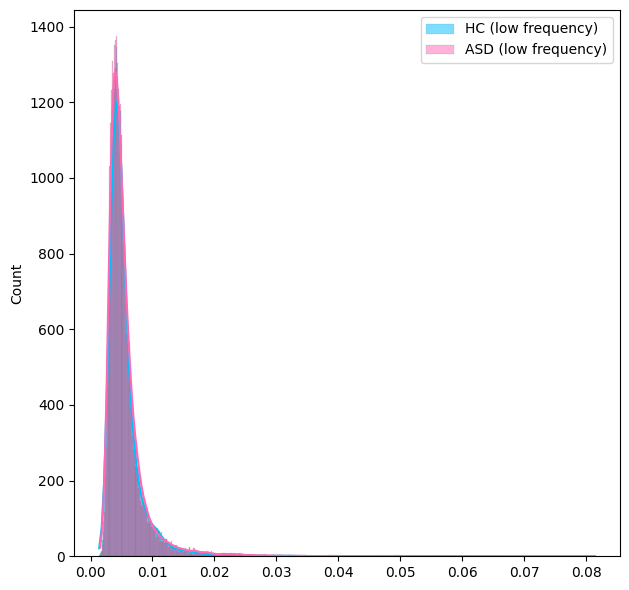

In [50]:
# 데이터를 1차원으로 변환
low_HC_flat = np.mean(low_HC, axis=0).flatten()
low_ASD_flat = np.mean(low_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(low_HC_flat, kde=True, color='deepskyblue', label='HC (low frequency)')
sns.histplot(low_ASD_flat, kde=True, color='hotpink', label='ASD (low frequency)')
plt.legend()
# plt.title('Histogram of low frequency range (attention matrix), averaged subjects')

plt.tight_layout()
plt.savefig('ABIDE_ASD_low_freq_histplot.png', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches='tight', 
    pad_inches=0.1,
    metadata=None)
plt.show()

## 6-3 ultralow frequency

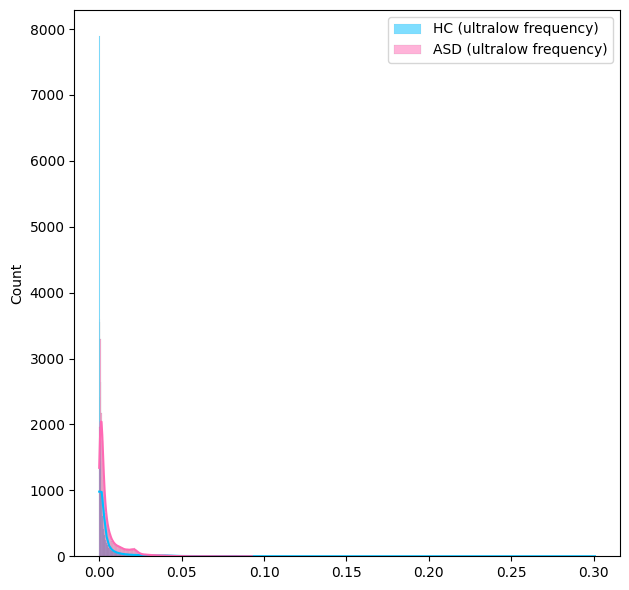

In [51]:
# 데이터를 1차원으로 변환
ultralow_HC_flat = np.mean(ultralow_HC, axis=0).flatten()
ultralow_ASD_flat = np.mean(ultralow_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(ultralow_HC_flat, kde=True, color='deepskyblue', label='HC (ultralow frequency)')
sns.histplot(ultralow_ASD_flat, kde=True, color='hotpink', label='ASD (ultralow frequency)')
plt.legend()
# plt.title('Histogram of ultralow frequency range (attention matrix), averaged subjects')

plt.tight_layout()
plt.savefig('ABIDE_ASD_ultralow_freq_histplot.png', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches='tight', 
    pad_inches=0.1,
    metadata=None)
plt.show()

# 07 attribution matrix distribution between ASD and HC

## 7-1 high frequency

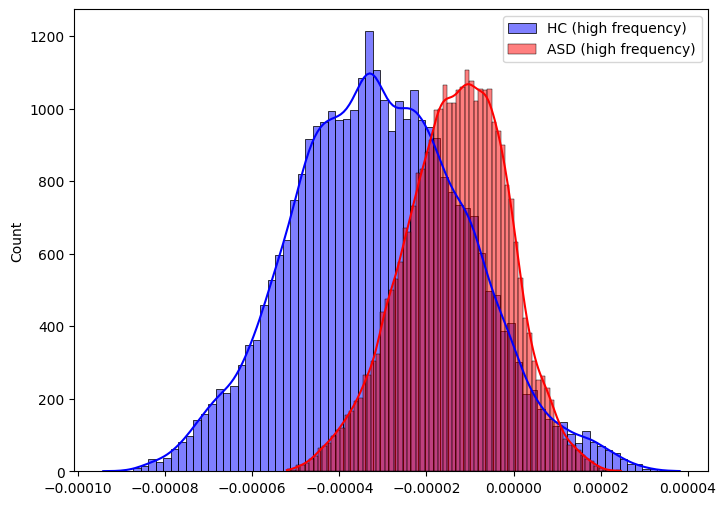

In [52]:
# 데이터를 1차원으로 변환
high_HC_flat = np.mean(high_contribution, axis=0).flatten()
high_ASD_flat = np.mean(high_contribution_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(high_HC_flat, kde=True, color='blue', label='HC (high frequency)')
sns.histplot(high_ASD_flat, kde=True, color='red', label='ASD (high frequency)')
plt.legend()
# plt.title('Histogram and KDE of high frequency range, averaged subjects')

plt.savefig('ABIDE_ASD_high_freq_attribution_mat_histplot.png', 
            dpi=600, 
            facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format=None,
            transparent=False, 
            bbox_inches=None, 
            pad_inches=0.1,
            metadata=None)
plt.show()

## 7-2 low frequency

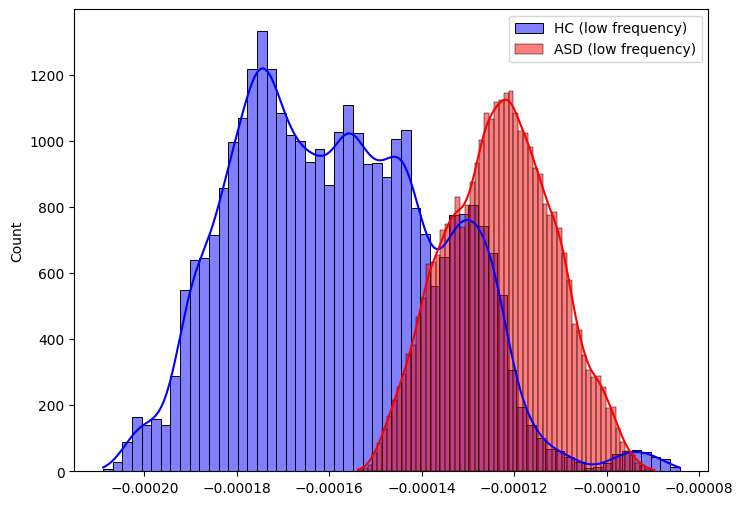

In [53]:
# 데이터를 1차원으로 변환
low_HC_flat = np.mean(low_contribution, axis=0).flatten()
low_ASD_flat = np.mean(low_contribution_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(low_HC_flat, kde=True, color='blue', label='HC (low frequency)')
sns.histplot(low_ASD_flat, kde=True, color='red', label='ASD (low frequency)')
plt.legend()
# plt.title('Histogram and KDE of low frequency range, averaged subjects')

plt.savefig('ABIDE_ASD_low_freq_attribution_mat_histplot.png', 
            dpi=600, 
            facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format=None,
            transparent=False, 
            bbox_inches=None, 
            pad_inches=0.1,
            metadata=None)
plt.show()

## 7-3 ultralow frequency

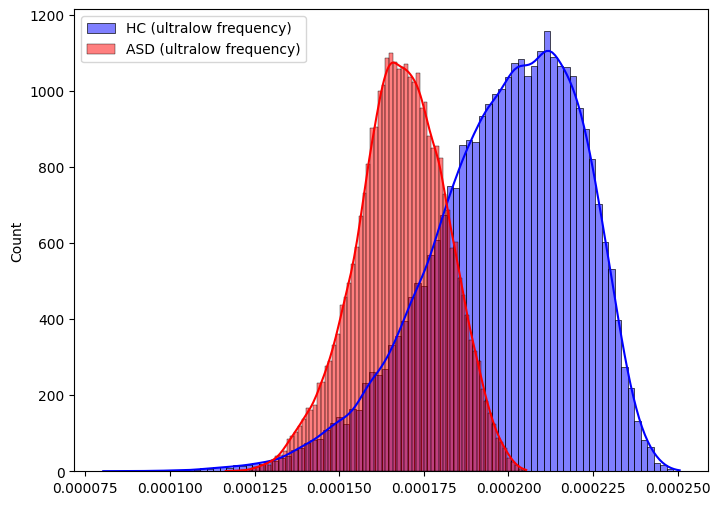

In [54]:
# 데이터를 1차원으로 변환
ultralow_HC_flat = np.mean(ultralow_contribution, axis=0).flatten()
ultralow_ASD_flat = np.mean(ultralow_contribution_ASD, axis=0).flatten()

# 히스토그램
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(ultralow_HC_flat, kde=True, color='blue', label='HC (ultralow frequency)')
sns.histplot(ultralow_ASD_flat, kde=True, color='red', label='ASD (ultralow frequency)')
plt.legend()
# plt.title('Histogram and KDE of ultralow frequency range, averaged subjects')
plt.savefig('ABIDE_ASD_ultralow_attribution_mat_freq_histplot.png', 
            dpi=600, 
            facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format=None,
            transparent=False, 
            bbox_inches=None, 
            pad_inches=0.1,
            metadata=None)
plt.show()